#Student Name: Pranav Mohan
#ECE 595 Machine Learning II
#Project 4: Adversarial Machine Learning - Student Code

In [1]:
#Install Cleverhans (version Cleverhans 2.1.0 is most compatable with Python 2.x)
%tensorflow_version 1.x
!pip install cleverhans==2.1.0
!pip install 'h5py==2.10.0' --force-reinstall
from google.colab import drive
drive.mount('/content/drive')

TensorFlow 1.x selected.
  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached numpy-1.21.4-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10 requires umap-learn, which is not installed.
tensorflow 1.15.2 requires gast==0.2.2, but you have gast 0.4.0 which is incompat

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.datasets import mnist
from keras import Sequential
from keras.models import load_model
from keras.layers import Dense, BatchNormalization, InputLayer, Flatten, Conv2D, MaxPooling2D, Dropout, LSTM, Reshape
from keras import backend
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod, MadryEtAl, DeepFool, CarliniWagnerL2
import os
from keras.callbacks import ModelCheckpoint
import pandas as pd


Using TensorFlow backend.


In [23]:
print(tf.__version__)

1.15.2


#Part 1: Training a target classifier

In [3]:
# Load data MNIST data and normalize to [0, 1]
(data_train, labels_train), (data_test, labels_test) = mnist.load_data()
data_train = (data_train)/255.; print(tf.shape(data_train))
data_test = (data_test)/255; print(tf.shape(data_test))

#Reshape training and testing data into 784-dimensional vectors 
data_train = data_train.reshape(-1,784); print(tf.shape(data_train))
data_test = data_test.reshape(-1,784);   print(tf.shape(data_test))
# data_train = tf.reshape(data_train,[-1,28,28,1]); print(tf.shape(data_train))
# data_test = tf.reshape(data_test,[-1,28,28,1]); print(tf.shape(data_train))

#Convert integer labels for training and testing data into one-hot vectors 
labels_train = keras.utils.np_utils.to_categorical(labels_train, num_classes=10);print(tf.shape(labels_train))
labels_test  = keras.utils.np_utils.to_categorical(labels_test , num_classes=10);print(tf.shape(labels_test))

num_samples=5000; n=28; num_channels=1; num_classes=10;

Tensor("Shape:0", shape=(3,), dtype=int32)
Tensor("Shape_1:0", shape=(3,), dtype=int32)
Tensor("Shape_2:0", shape=(2,), dtype=int32)
Tensor("Shape_3:0", shape=(2,), dtype=int32)
Tensor("Shape_4:0", shape=(2,), dtype=int32)
Tensor("Shape_5:0", shape=(2,), dtype=int32)


In [4]:

#Create classifier architecture, compile it, and train it
def CNN():
    model = Sequential()
    # x=(tf.keras.Input()
    # y=(tf.keras.layers.Dense(units=num_classes)      
    #model.add(InputLayer(n,n,num_channels))
    #model.add(InputLayer(input_shape=(n,n,num_channels)))
    #model.add(Conv2D(256, kernel_size=(3,3), activation='relu',input_shape=(n,n,num_channels)))
    #model.add(Dropout(.3))
    #model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='Valid', data_format=None))
    #model.add(Conv2D(128, kernel_size=(3,3), 
    #                 activation='relu',input_shape=(n,n,num_channels)))
    #model.add(Dropout(.3))
    #model.add(MaxPooling2D(pool_size=(2,2), strides=None, 
    #                       padding='Valid', data_format=None))
    model.add(Dense(100, activation=None, kernel_initializer="normal", input_dim=(784)))
    model.add(BatchNormalization())
    model.add(Dense(100,activation='relu',kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Dense(10,activation='softmax'))
    #model= tf.keras.Model
    return model

#Create instance of CNN model graph
model = CNN()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
#Compile model using an appropriate loss and optimizer algorithm
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.train.AdamOptimizer(learning_rate=0.001), metrics=['accuracy'])

#Train the model and assign training meta-data to a variable
model_mdata =  model.fit(data_train, labels_train, epochs=50,validation_data=(data_test, labels_test),batch_size=256, shuffle=True,)#steps_per_epoch=1,)
hist_df = pd.DataFrame(model_mdata.history) 
CNN_dropout_hidden_file = 'CNN_mdata.csv'
with open(CNN_dropout_hidden_file, mode='w') as f:
    hist_df.to_csv(f)

#Print accuracy of model on testing set after training 
scores_dropout_hidden = model.evaluate(data_train, labels_train)
model.save("/content/drive/MyDrive/ECE595DL/Project4/mnist")




Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.3082 - accuracy: 0.9103 - val_loss: 0.2302 - val_accuracy: 0.9485
Epoch 2/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.1421 - accuracy: 0.9604 - val_loss: 0.1201 - val_accuracy: 0.9652
Epoch 3/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.1024 - accuracy: 0.9712 - val_loss: 0.1011 - val_accuracy: 0.9704
Epoch 4/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.0796 - accuracy: 0.9777 - val_loss: 0.1023 - val_accuracy: 0.9687
Epoch 5/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.0653 - accuracy: 0.9813 - val_loss: 0.0940 - val_accuracy: 0.9716
Epoch 6/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.0548 - accuracy: 0.9843 - val_loss: 0.0843 - val_accuracy: 0.9762
Epoch 7/50
60000/60000 [==============================] - 2s 32us

/tensorflow-1.15.2/python3.7/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [27]:
model.save("/content/drive/MyDrive/ECE595DL/Project4/mnist_classified_CNN4.h5")

/tensorflow-1.15.2/python3.7/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


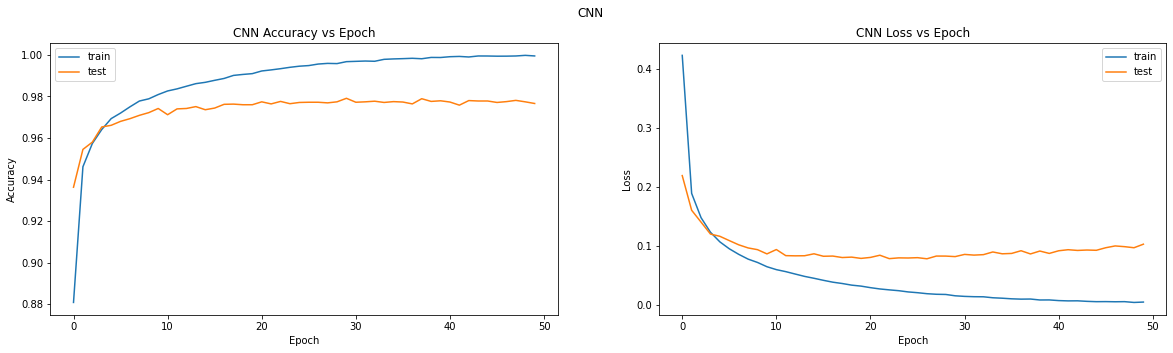

In [28]:
def plotting(history,title):
  plt.figure(figsize=(20,5))
  plt.subplot(121)
  plt.plot(history.accuracy)
  plt.plot(history.val_accuracy)
  plt.title('CNN Accuracy vs Epoch'); plt.ylabel('Accuracy'); plt.xlabel('Epoch')
  plt.legend(['train','test']); 
  plt.subplot(122);
  plt.plot(history.loss)
  plt.plot(history.val_loss)
  plt.title('CNN Loss vs Epoch'); plt.ylabel('Loss'); plt.xlabel('Epoch')
  plt.legend(['train','test']); plt.suptitle(title); plt.show();
#Plot loss vs epoch
CNN_file = 'CNN_mdata.csv'
history=pd.read_csv(CNN_file); 
plotting(history,'CNN')

In [29]:
#Print accuracy of classifier on MNIST testing data
print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))

Accuracy: 99.90%


In [6]:

# Edit the classifier name fed into KerasModel Wrapper with the name of the 
#!pip uninstall h5py
#!pip install h5py==2.10.0 --force-reinstall
#%tensorflow_version 1.x
#import tensorflow as tf; print(tf.__version__)
#from  tensorflow.keras.models import load_model
#model = load_model('/content/drive/MyDrive/ECE595DL/Project4/mnist_classified_CNN.h5')
#checkpoint_path = "/content/drive/MyDrive/ECE595DL/Project4/cp2.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

#model=CNN();#model.summary()

#latest = tf.train.latest_checkpoint(checkpoint_dir)
#print(latest)
# Create a new model instance

# Load the previously saved weights
#model.load_weights("/content/drive/MyDrive/ECE595DL/Project4/mnist_classified_CNN") #tf.saved_model.load(checkpoint_path)
#model = tf.keras.models.load_model('/content/drive/MyDrive/ECE595DL/Project4/cp.ckpt')
#model = tf.keras.models.load_model('/content/mnist_classified_CNN.json')
#model = tf.keras.models.load_model('/content/mnist_classified_CNN2.h5',compile=True)
#model.load_model('/content/drive/MyDrive/ECE595DL/Project4/cp.ckpt')

#model = keras.models.load_model('/content/mnist_classified_CNN.json')
#model = tf.keras.models.load_model('/content/mnist_classified_CNN.json')

# Check its architecture
#model.summary()
# load('mnist_classified_CNN.h5')
#Get TensorFlow Session to pass into Cleverhans modules
#model = load_model("/content/drive/MyDrive/ECE595DL/Project4/mnist_classified_CNN2.h5")

model2 =  load_model("/content/drive/MyDrive/ECE595DL/Project4/mnist")
sess = tf.compat.v1.keras.backend.get_session()

#Create wrapper for classifier model so that it can be passed into Cleverhans modules
wrap = KerasModelWrapper(model2)

/tensorflow-1.15.2/python3.7/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


#Part 2: The Fast Gradient Method (FGM)

In [31]:
#Implementing the FGSM attack
backend.set_learning_phase(0);

fgm = FastGradientMethod(wrap, sess=sess);

#Attack parameters
fgm_params = {'eps': 0.25,'clip_min': 0.0,'clip_max': 1.0};

#Generate adversarial data
fgm_data = fgm.generate_np(data_test, **fgm_params)

#Evaluate accuracy on target classifier 
backend.set_learning_phase(0)
[loss_fgm, acc_fgm] = model.evaluate(fgm_data, labels_test, batch_size = 512)
print("Test Accuracy: {:0.3f}%".format(acc_fgm*100))

10000/10000 [==============================] - 0s 9us/step
Test Accuracy: 3.140%


(10000, 784)


Text(0.5, 1.0, 'Generated')

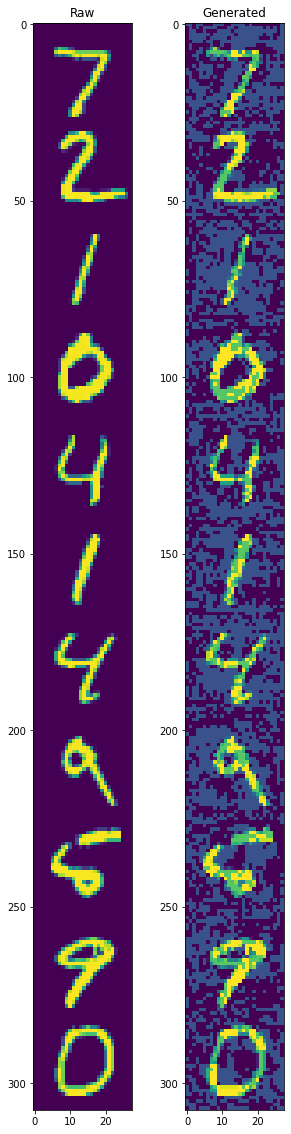

In [42]:
#Show ten original samples and their corresponding adversarial samples
print(fgm_data.shape)
plt.figure(figsize=(5,20))
plt.subplot(121)
plt.imshow(data_test[:11].reshape(-1,28)); plt.title('Raw')
plt.subplot(122)
plt.imshow(fgm_data[:11].reshape(-1,28)); plt.title('Generated')

In [33]:
#Implementing Detection via Autoencoders
def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=(784)))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create and train the autoencoder using the mean squared error loss and adam optimizer
ae = autoencoder()

ae.compile(loss=tf.keras.losses.mean_squared_error, optimizer=tf.train.AdamOptimizer(learning_rate=0.001), metrics=['accuracy'])
data_train = data_train.reshape(-1,784);
ae.fit(data_train, data_train, batch_size=1028, shuffle=True,epochs=50)#steps_per_epoch=1,)


Epoch 1/50
60000/60000 [==============================] - 6s 105us/step - loss: 0.0718 - accuracy: 0.0071
Epoch 2/50
60000/60000 [==============================] - 6s 101us/step - loss: 0.0333 - accuracy: 0.0116
Epoch 3/50
60000/60000 [==============================] - 6s 102us/step - loss: 0.0220 - accuracy: 0.0099
Epoch 4/50
60000/60000 [==============================] - 6s 102us/step - loss: 0.0161 - accuracy: 0.0100
Epoch 5/50
60000/60000 [==============================] - 6s 101us/step - loss: 0.0131 - accuracy: 0.0104
Epoch 6/50
60000/60000 [==============================] - 6s 101us/step - loss: 0.0112 - accuracy: 0.0120
Epoch 7/50
60000/60000 [==============================] - 6s 102us/step - loss: 0.0098 - accuracy: 0.0128
Epoch 8/50
60000/60000 [==============================] - 6s 101us/step - loss: 0.0090 - accuracy: 0.0132
Epoch 9/50
60000/60000 [==============================] - 6s 102us/step - loss: 0.0084 - accuracy: 0.0133
Epoch 10/50
60000/60000 [=====================

In [39]:
#Using the autoencoder for detection and to determine a threshold 
# Create adversarial examples using FGSM on training data
fgm_exam=fgm.generate_np(data_train,**fgm_params)
fgm_recon=ae.predict(fgm_exam)

# Obtain reconstruction errors on training set and determine a threshold 
error = keras.losses.mean_absolute_error(fgm_exam,fgm_recon)

# Convert error tensor into NumPy array 
# CHANGE NAME 'error' TO WHAT YOU CALLED IT ABOVE
error = error.eval(session=sess)

# Determine threshold (based on min in this case) and print it 
min_error = min(error)
thresh = min_error; print('Threshold value is {:.3f}'.format(min_error))
adv_test = ae.predict(fgm_data)

# Calculate error of adversarial testing set
error = keras.losses.mean_absolute_error(adv_test,fgm_data)
error = error.eval(session=sess)

# Determine how many examples are above threshold and consider them adversarial
# (true positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold

# Print number of true positive samples
print("True positive: {:d}".format(np.size(np.where(error > thresh))))

# Determine false positives on benign testing set


# Determine how many examples are above threshold and consider them adversarial
# (false positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
fgm_recon=ae.predict(data_test)
error = keras.losses.mean_absolute_error(data_test,fgm_recon)
error = error.eval(session=sess)

# Print number of false positive samples
print("False positive: {:d}".format(np.size(np.where(error > thresh))))


Threshold value is 0.102
True positive: 10000
False positive: 0


#Part 3: Projected Gradient Descent

In [41]:
#Implementing the PGD attack

#PGD Instance on trained classifier from Part 1
pgd = MadryEtAl(wrap, sess=sess)

#Attack parameters
pgd_params = {'eps': 0.25, 'eps_iter':0.01, 'nb_iter': 20, 'clip_min': 0.0,'clip_max': 1.0};

#Generate adversarial data
pgd_data = pgd.generate_np(data_test, **pgd_params)

#Evaluate accuracy of perturbed data on target classifier
backend.set_learning_phase(0)
[loss_pgd, acc_pgd] = model.evaluate(pgd_data, labels_test, batch_size = 512)
print("Test Accuracy: {:0.3f}%".format(acc_pgd*100))


10000/10000 [==============================] - 0s 9us/step
Test Accuracy: 1.180%


(10000, 784)


Text(0.5, 1.0, 'Generated')

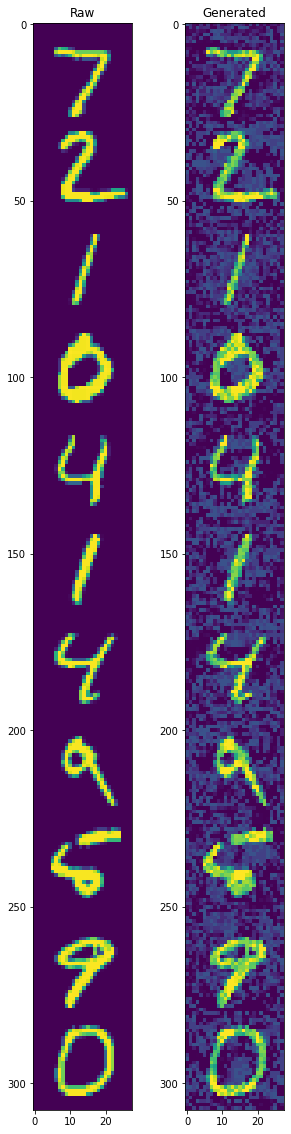

In [43]:
#Show ten original samples and their corresponding adversarial samples
#Show ten original samples and their corresponding adversarial samples
print(pgd_data.shape)
plt.figure(figsize=(5,20))
plt.subplot(121)
plt.imshow(data_test[:11].reshape(-1,28)); plt.title('Raw')
plt.subplot(122)
plt.imshow(pgd_data[:11].reshape(-1,28)); plt.title('Generated')

In [45]:
#Implementing the adversarial training defense
pgd_model=model;
pgd_data_train = pgd.generate_np(data_train, **pgd_params)
data_train_pgd = np.concatenate([data_train,pgd_data_train])
labels_train_pgd = np.concatenate([labels_train,labels_train])
pgd_mdata=pgd_model.fit(data_train_pgd,labels_train_pgd,validation_data=(pgd_data,labels_test),epochs=50, batch_size=256)

Train on 120000 samples, validate on 10000 samples
Epoch 1/50
120000/120000 [==============================] - 4s 30us/step - loss: 0.0337 - accuracy: 0.9899 - val_loss: 0.2602 - val_accuracy: 0.9743
Epoch 2/50
120000/120000 [==============================] - 4s 30us/step - loss: 0.0298 - accuracy: 0.9913 - val_loss: 0.2648 - val_accuracy: 0.9744
Epoch 3/50
120000/120000 [==============================] - 4s 29us/step - loss: 0.0269 - accuracy: 0.9918 - val_loss: 0.2603 - val_accuracy: 0.9754
Epoch 4/50
120000/120000 [==============================] - 4s 30us/step - loss: 0.0246 - accuracy: 0.9925 - val_loss: 0.2614 - val_accuracy: 0.9742
Epoch 5/50
120000/120000 [==============================] - 4s 30us/step - loss: 0.0216 - accuracy: 0.9932 - val_loss: 0.2675 - val_accuracy: 0.9749
Epoch 6/50
120000/120000 [==============================] - 4s 30us/step - loss: 0.0201 - accuracy: 0.9936 - val_loss: 0.2688 - val_accuracy: 0.9756
Epoch 7/50
120000/120000 [=============================

In [47]:
#Using the defense to evaluate the accuracy of the perturbed data
(_,pgd_test_acc)=pgd_model.evaluate(pgd_data,labels_test,batch_size=512)
print('PGD accuracy = : {:0.2f}'.format(pgd_test_acc*100))

10000/10000 [==============================] - 0s 9us/step
PGD accuracy = : 97.50


#Part 4: Carlini and Wagner Attack

In [40]:
#Implementing the CW attack

#CW Instance on trained classifier from Part 1
cwa = CarliniWagnerL2(wrap, sess=sess)

#Attack parameters
cwa_params = {'binary_search_step': 1, 'y':None, 'learning_rate': 1.25, 'batch_size': 16, 'initial_const': 10, 'clip_min': 0.0,'clip_max': 1.0};


#Generate adversarial data
cwa_data_test = cwa.generate_np(data_test, **cwa_params)

/usr/local/lib/python3.7/dist-packages/cleverhans/attacks.py:179: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "


In [41]:
#Evaluate accuracy of perturbed data on target classifier
backend.set_learning_phase(0)
[_, acc_cwa] = model.evaluate(cwa_data_test, labels_test, batch_size = 512)
print("Test Accuracy: {:0.3f}%".format(acc_cwa*100))

10000/10000 [==============================] - 0s 9us/step
Test Accuracy: 1.690%


(10000, 784)


Text(0.5, 1.0, 'Generated')

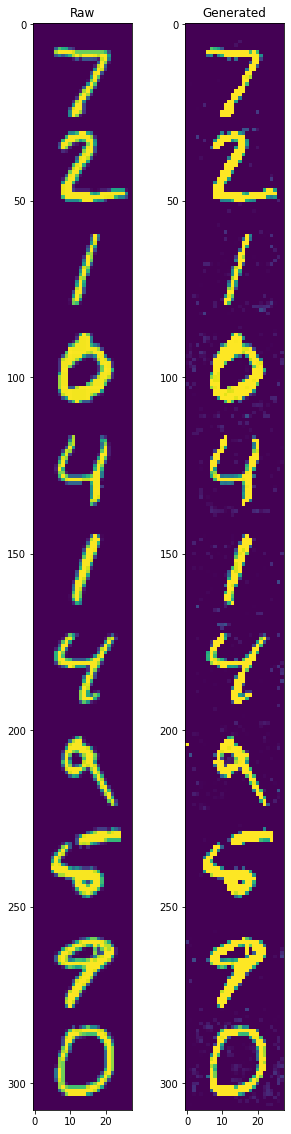

In [42]:
#Show ten original samples and their corresponding adversarial samples
print(cwa_data_test.shape)
plt.figure(figsize=(5,20))
plt.subplot(121)
plt.imshow(data_test[:11].reshape(-1,28)); plt.title('Raw')
plt.subplot(122)
plt.imshow(cwa_data_test[:11].reshape(-1,28)); plt.title('Generated')

In [43]:
#Implementing the dimensionality reduction (PCA) defense 

#Calculate PCA projection
pca = PCA(100)
pca.fit(data_train)
pca_train = pca.transform(data_train)
pca_test = pca.transform(data_test)

#Transform perturbed CW data using the subspace from the original training data
pca_cwa_test = pca.transform(cwa_data_test)

# create model for PCA
def pca_model():
    model = Sequential()
    
    model.add(Dense(100, activation=None, kernel_initializer="normal", input_dim=(100)))
    model.add(BatchNormalization())
    model.add(Dense(100,activation='relu',kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Dense(10,activation='softmax'))

    return model

#Create model graph, compile it, and train it using pca_train lables_train 
pca_model=pca_model();
pca_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.train.AdamOptimizer(learning_rate=0.001), metrics=['accuracy'])

#Train the model and assign training meta-data to a variable
pca_model_mdata =  pca_model.fit(pca_train, labels_train, epochs=50,validation_data=(pca_test, labels_test),batch_size=256, shuffle=True,)#steps_per_epoch=1,)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.4611 - accuracy: 0.8803 - val_loss: 0.1699 - val_accuracy: 0.9505
Epoch 2/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.1450 - accuracy: 0.9575 - val_loss: 0.1244 - val_accuracy: 0.9637
Epoch 3/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.1092 - accuracy: 0.9687 - val_loss: 0.1071 - val_accuracy: 0.9686
Epoch 4/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.0914 - accuracy: 0.9742 - val_loss: 0.0987 - val_accuracy: 0.9714
Epoch 5/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.0796 - accuracy: 0.9772 - val_loss: 0.0892 - val_accuracy: 0.9734
Epoch 6/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0710 - accuracy: 0.9803 - val_loss: 0.0876 - val_accuracy: 0.9740
Epoch 7/50
60000/60000 [==============================] - 1s 18us/st

In [44]:
#Using the defense (and comparing to baseline accuracy)
[_, acc_pca_cwa] = pca_model.evaluate(pca_cwa_test, labels_test, batch_size = 512)
print("Test Accuracy: {:0.3f}%".format(acc_pca_cwa*100))

10000/10000 [==============================] - 0s 7us/step
Test Accuracy: 95.830%


#Part 5: DeepFool 

In [7]:
#Implementing the DeepFool attack

#DeepFool Instance on trained classifier from Part 1
deepf = DeepFool(wrap,sess=sess)

#Attack parameters
deepf_params = {'nb_candidate': 10, 'max_iter':50,'clip_min': 0.0,'clip_max': 1.0};

#Generate adversarial data
deepf_data_test = deepf.generate_np(data_test, **deepf_params)



Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [8]:
#Evaluate accuracy of perturbed data on target classifier
[_, acc_deepf] = model.evaluate(deepf_data_test, labels_test, batch_size = 512)
print("Test Accuracy: {:0.3f}%".format(acc_deepf*100))

10000/10000 [==============================] - 0s 10us/step
Test Accuracy: 1.570%


(10000, 784)


Text(0.5, 1.0, 'Generated')

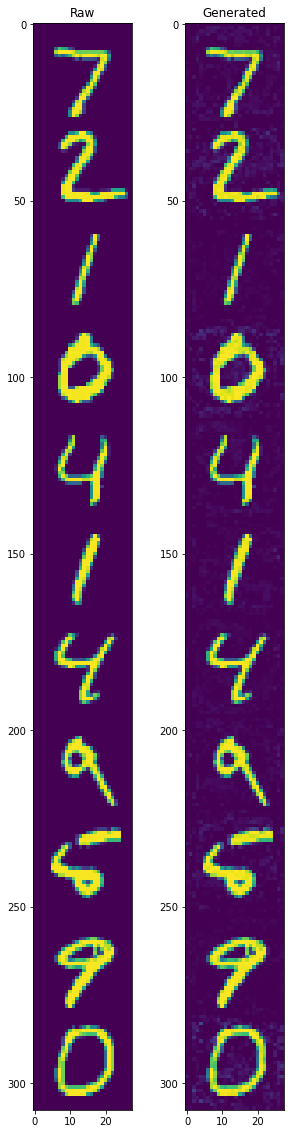

In [9]:
#Show ten original samples and their corresponding adversarial samples
#Show ten original samples and their corresponding adversarial samples
print(deepf_data_test.shape)
plt.figure(figsize=(5,20))
plt.subplot(121)
plt.imshow(data_test[:11].reshape(-1,28)); plt.title('Raw')
plt.subplot(122)
plt.imshow(deepf_data_test[:11].reshape(-1,28)); plt.title('Generated')

In [10]:
#Implementing the Denoising Autoencoder Defense

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create training data for DAE 
fgm_params = {'eps': 0.25,'clip_min': 0.0,'clip_max': 1.0};
df_attack_data_train = deepf.generate_np(data_train, **fgm_params)
data_total_train = np.concatenate([df_attack_data_train, data_train])
data_total_label = np.concatenate([data_train, data_train])

#Create and train DAE graph
deepf_model = autoencoder()
deepf_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.train.AdamOptimizer(learning_rate=0.001), metrics=['accuracy'])
print(tf.shape(df_attack_data_train))
deepf_model.fit(data_total_train,data_total_train,epochs=50,batch_size=256)

/usr/local/lib/python3.7/dist-packages/cleverhans/attacks.py:179: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "


Tensor("Shape_6:0", shape=(2,), dtype=int32)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
120000/120000 [==============================] - 19s 158us/step - loss: 567.6763 - accuracy: 0.0092
Epoch 2/50
120000/120000 [==============================] - 18s 153us/step - loss: 546.7927 - accuracy: 0.0122
Epoch 3/50
120000/120000 [==============================] - 19s 157us/step - loss: 544.3108 - accuracy: 0.0141
Epoch 4/50
120000/120000 [==============================] - 19s 160us/step - loss: 543.1025 - accuracy: 0.0146
Epoch 5/50
120000/120000 [==============================] - 19s 157us/step - loss: 542.3922 - accuracy: 0.0162
Epoch 6/50
120000/120000 [==============================] - 18s 151us/step - loss: 541.8903 - accuracy: 0.0159
Epoch 7/50
120000/120000 [==============================] - 18s 150us/step - loss: 541.5871 - accuracy: 0.0166
Epoch 8/50
120000/120000 [==============================] - 18s 154us/step - loss: 5

In [11]:
#Using the defense

#Use DAE to to remove adversarial perturbation 
free_noise = deepf_model.predict(deepf_data_test)

#Evaluate accuracy of FGM samples after denoising 
[_, acc_deepf] = model.evaluate(free_noise, labels_test, batch_size = 512)
print("Test Accuracy: {:0.3f}%".format(acc_deepf*100))

10000/10000 [==============================] - 0s 9us/step
Test Accuracy: 79.730%


Text(0.5, 1.0, 'Denoising')

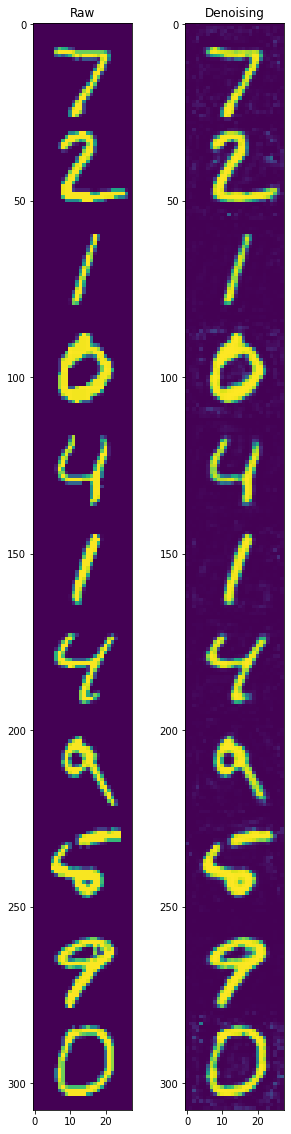

In [12]:
#Show ten samples of adversarial samples after denoising
#Show ten original samples and their corresponding adversarial samples
plt.figure(figsize=(5,20))
plt.subplot(121)
plt.imshow(data_test[:11].reshape(-1,28)); plt.title('Raw')
plt.subplot(122)
plt.imshow(free_noise[:11].reshape(-1,28)); plt.title('Denoising')